## Mass Mobilization Research Notebook

In [1]:
#%pip install numpy pandas pandas_gbq matplotlib networkx pytrends
import numpy as np
import pandas as pd
import pandas_gbq 
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
from pytrends.request import TrendReq
import os

### GDelt

In [2]:
query = """
    SELECT * FROM `gdelt-bq.full.events` WHERE EventBaseCode = "014" LIMIT 10;
"""

event_df = pandas_gbq.read_gbq(query, project_id="gdelt-d-379201")
event_df

GenericGBQException: Reason: 403 POST https://bigquery.googleapis.com/bigquery/v2/projects/gdelt-d-379201/jobs?prettyPrint=false: Access Denied: Project gdelt-d-379201: User does not have bigquery.jobs.create permission in project gdelt-d-379201.

Location: None
Job ID: 577b9632-bb31-45fe-867b-41ea197eda4c


### Google Trends

In [3]:
def load_keywords(kw_list):
    trends = TrendReq(hl="en-US", tz=360)
    trends.build_payload(kw_list, timeframe='today 5-y')
    kw_trend_df = trends.interest_over_time()
    
    return kw_trend_df
    
def add_keywords(new_kw_list, kw_trend_df):
    new_kw_trend_df = load_keywords(new_kw_list)
    
    for col in new_kw_trend_df.columns:
        kw_trend_df[col] = new_kw_trend_df[col]
    
    return kw_trend_df

KEYWORDS = ["blm", "defund", "abolish", "george floyd", "police", "prison", "protest", "justice", "trump", "all lives matter", "blm", "defund", "abolish", "police"]

### Load Keywords in Chunks

In [4]:
n = 4
chunks = len(KEYWORDS) // n
kw_trend_df = pd.DataFrame()

for i in range(chunks):
    kw_chunk = KEYWORDS[(i * n):((i + 1) * n)]
    kw_trend_df = add_keywords(kw_chunk, kw_trend_df)

<Axes: xlabel='date'>

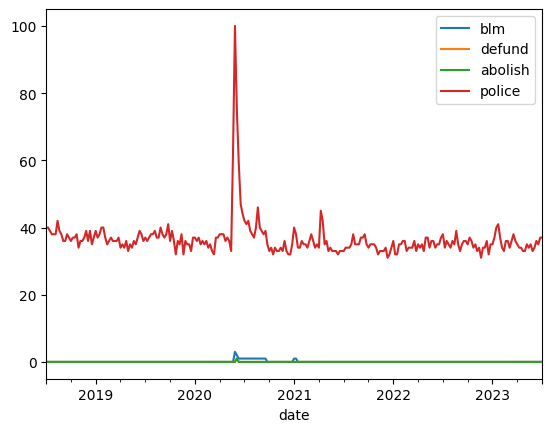

In [5]:
kw_trend_df.plot(y=["blm", "defund", "abolish", "police"], use_index=True)

#### Plotting as a Network

In [ ]:
SIGNIFICANCE_THRESHOLD = 0.3

def generate_correlation_graph(trend_df, autocor=False, threshold=SIGNIFICANCE_THRESHOLD):
    kw_list = list(trend_df.columns)
    kw_list.remove("isPartial")

    kws = len(kw_list)
    correlations = np.zeros((kws, kws))
    kw_net = nx.Graph()
    
    for i in range(kws):
        kw_net.add_node(i, label=kw_list[i])
        
        for j in range(kws):
                if autocor or i != j:
                    corr = kw_trend_df[kw_list[i]].corr(kw_trend_df[kw_list[j]])
                    
                    if np.isnan(corr):
                        print(kw_list[i], kw_list[j])
                    
                    if corr != 0 and not np.isnan(corr):
                        kw_net.add_edge(i, j, corr=corr, weight=np.abs(corr))
        
    return kw_net

DEFAULT_WIDTH_FN = lambda edge: 3 * edge["corr"] ** 2

def choose_color(edge):
    if edge["corr"] > 0:
        return "lightgreen"
    else:
        return "red"

def draw(graph, layout=nx.spring_layout, width_fn=DEFAULT_WIDTH_FN):
    pos = layout(graph)
    edges = graph.edges()
    weights = [width_fn(graph[i][j]) for i,j in edges]
    edge_colors = [choose_color(graph[i][j]) for i,j in edges]
    labels = nx.get_node_attributes(graph, "label")

    nx.draw_networkx_labels(kw_net, pos, labels=labels)
    nx.draw(
        graph,
        pos,
        width=list(weights),
        node_color="lightgrey",
        edge_color=edge_colors
    )

In [ ]:
kw_net = generate_correlation_graph(kw_trend_df, threshold=0)
draw(kw_net, layout=nx.spring_layout)

### C-SPAN

#### Data Aggregation

In [7]:
FIRST_CONGRESS = 97
LAST_CONGRESS = 114
congresses = range(FIRST_CONGRESS, LAST_CONGRESS + 1)

def full_speeches_exist():
    for congress in congresses:
        if not os.path.isfile(f"data/full/full_{get_num(congress)}.csv"):
            return False
    return True

def get_num(congress):
    if congress < 100:
        return "0" + str(congress)
    else:
        return str(congress)

def get_full_speeches():
    for congress in congresses:
        num = get_num(congress)

        descsDf = pd.read_csv(f"CongressData/descs/descr_{num}.txt", sep="|", encoding = 'unicode_escape', on_bad_lines='skip')
        descsDf["speech_id"] = descsDf["speech_id"].astype("string")

        speechesDf = pd.read_csv(f"CongressData/speeches/speeches_{num}.txt", sep="|", encoding = 'unicode_escape', on_bad_lines='skip')
        speechesDf["speech_id"] = speechesDf["speech_id"].astype("string")

        speakersDf = pd.read_csv(f"CongressData/speakers/{num}_SpeakerMap.txt", sep="|", encoding = 'unicode_escape', on_bad_lines='skip')
        speakersDf["speech_id"] = speechesDf["speech_id"].astype("string")

        descsDf = descsDf.merge(speechesDf, on="speech_id", how="outer")
        descsDf = descsDf.merge(speakersDf, on="speech_id", how="outer")

        descsDf.to_csv(f"CongressData/full/full_{num}.csv")

if not full_speeches_exist():
    # get_full_speeches() //uncomment if you actually wanna redo all the data consolidation
    print("Complete!")

Complete!


#### Converting C-SPAN to C-TRENDS

In [8]:
FIRST_CONGRESS = 97
LAST_CONGRESS = 114
congresses = range(FIRST_CONGRESS, LAST_CONGRESS + 1)

num = get_num(FIRST_CONGRESS)

descs = pd.read_csv(f"CongressData/descs/descr_{num}.txt", sep="|", encoding = 'unicode_escape', on_bad_lines='skip', low_memory=False)
full_speech = pd.read_csv(f"CongressData/full/full_{num}.csv", low_memory=False )

In [11]:
def to_datetime(col):
    date = col.astype("str").str
    return pd.to_datetime(date[:4] + "/" + date[4:6] + "/" + date[6:])

def phrase_title(phrase):
    return f"count_{phrase}"
def get_ctrends(phrases=[], disag=[]):
    ctrends = pd.DataFrame()
    phrase_column_titles = [phrase_title(i) for i in phrases]  # this creates a list of phrases with "count_" in front

    # add columns to ctrends df
    ctrends = ctrends.reindex(columns=["date", *phrase_column_titles, *disag])

    #list of partial ctrends
    temp = []

    for congress in congresses:
        num = get_num(congress)

        full_speech = pd.read_csv(f"CongressData/full/full_{num}.csv", low_memory=False)
        full_speech = full_speech[[*disag, "speech", "date"]]

        for phrase in phrases:
            full_speech[f"count_{phrase}"] = full_speech["speech"].str.count(phrase)

        ctrends_speech = full_speech.groupby(["date", *disag]).sum(numeric_only=True).reset_index()
        ctrends_speech = ctrends_speech[[*phrase_column_titles, *disag, "date"]]
        temp.append(ctrends_speech)

    ctrends= pd.concat(temp)

    ctrends["date"] = to_datetime(ctrends["date"])

    return ctrends


ctrends = get_ctrends(phrases=KEYWORDS, disag=["party"])
ctrends.to_csv("ctrends.csv")
print("Complete!")

Complete!
